# Introduction to xarray

Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!
Xarray introduces labels in the form  of dimensions, coordinates and attributes on top of raw NumPy-like multidimensional arrays

<img src="http://xarray.pydata.org/en/stable/_images/dataset-diagram.png" align="center" width="40%">

* Labelled
* Multidimensional
* Efficient



## Core data structures

Xarray provides two core data structures: the `DataArray` and `Dataset`, which build upon and extend the core strengths of NumPy and pandas. 
Both data structures are fundamentally N-dimensional:

**xarray.DataArray** The DataArray class is used to attach a name, dimension names, labels, and attributes to an array - it is a fancy, labelled version of a numpy.ndarray.

** xarray.Dataset** is a multi-dimensional, in-memory array database xarray - it is a collection of multiple DataArrays which share dimensions.



### Xarray
The Xarray package wraps around Dask Array, and so offers the same scalability, but also adds convenience when dealing with complex datasets. In particular Xarray can help with the following:

* Manage multiple arrays together as a consistent dataset
* Read from a stack of HDF or NetCDF files at once
* Switch between Dask Array and NumPy with a consistent API

### I/O

One of Xarray's most widely used features is its ability to read from and write
to a variety of data formats. For example, Xarray can read the following
formats:

- [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) / GRIB (via
  `open_dataset` / `open_mfdataset`, `to_netcdf` / `save_mfdataset`)
- [Zarr](https://zarr.readthedocs.io/en/stable/) (via `open_zarr`, `to_zarr`)
- [GeoTIFF](https://gdal.org/drivers/raster/gtiff.html) /
  [GDAL rasters](https://svn.osgeo.org/gdal/tags/gdal_1_2_5/frmts/formats_list.html)
  (via `open_rasterio`)

## What is Dask?

Dask is a flexible parallel computing library for analytic computing. Dask
provides dynamic parallel task scheduling and high-level big-data collections
like `dask.array` and `dask.dataframe`, and an extensive suite of deployment
options. 

<img src="https://docs.dask.org/en/latest/_images/dask-overview.svg" 
     width="45%" 
     align=center
     alt="Dask overview">

Basically, dask creates a **computational graph** of your processing steps, and then executes it as effeciently as possible - it describes what need to be done and what depends on what and 
**ONLY** load data that needs to load into memory and it **ONLY** processes things once!
 

## What is a Dask array?

Dask divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory.
Unlike NumPy, which has eager evaluation, operations on Dask arrays are lazy. Operations queue up a series of tasks mapped over blocks, and no computation is performed until you actually ask values to be computed (e.g., to print results to your screen or write to disk). At that point, data is loaded into memory and computation proceeds in a streaming fashion, block-by-block.

* Parallel: Uses all of the cores on your computer
* Larger-than-memory: Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
* Blocked Algorithms: Perform large computations by performing many smaller computations

<img src="https://docs.dask.org/en/latest/_images/array.png" align="center" width="20%">





In [1]:
# Import modules


import xarray as xr
from pathlib import Path
import datetime
from datetime import datetime
from glob import glob
import os
import pandas as pd
from shapely import wkt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
import dask 
from dask import compute
from dask import delayed
import numpy as np
import fnmatch
import pandas as p

In [4]:
# Define functions
def append_bands(scene_dir):
    """Open each band as an xarray using dask chunks and append to a list 

    :type scene_dir: pathlib.PosixPath
    :rtype bands: list
    :rtype afine: Affine (rasterio)
    """  
    bands = []
    for band_path in scene_dir.glob('*.tif'):
        band = xr.open_rasterio(band_path, chunks={'x':512, 'y':512}) 
        affine = Affine(*band.attrs['transform'])
        band['band'] = [band_path.stem.split('_')[-1]]
        bands.append(band) 
    return bands, affine
def append_scenes(path):
    """Concat all time series data 

    :type path: pathlib.PosixPath
    :rtype scenes: list
    :rtype afine: Affine (rasterio)
    """  
    scenes = []
    for scene in path.glob('*/'):
        bands, affine = append_bands(scene)
        scene = xr.concat(bands, dim='band')
        scenes.append(scene)
    return scenes, affine
def paths_to_datetimeindex(path):
    return  [datetime.strptime(date.name.split('_')[1][:8], '%Y%m%d') for date in path.glob("*")]

In [6]:
# Get time series

path_ = Path('/media/data/elisavet/data/tmp/grand-est_2018/test')
time_var = xr.Variable('time', paths_to_datetimeindex(path_))
scenes, affine = append_scenes(path_)
time_series_scenes = xr.concat(scenes, dim=time_var)

In [7]:
time_series_scenes

,Array,Chunk
Bytes,9.41 GB,524.29 kB
Shape,"(3, 14, 8572, 13071)","(1, 1, 512, 512)"
Count,92862 Tasks,18564 Chunks
Type,uint16,numpy.ndarray


In [8]:

from dask.distributed import LocalCluster, Client

cluster = LocalCluster() 
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45115 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 20 Memory: 134.85 GB


This cluster manager starts a scheduler on your local machine, and then starts the workers for the CPU cores that it finds on the machine.
When we create a Client object it registers itself as the default Dask scheduler. All .compute() methods will automatically start using the distributed system.


## Parallelism using the dask.distributed scheduler

At the previous cell of this notebook, we started a local Dask Cluster and Client. 

### Dask Schedulers

The Dask _Schedulers_ orchestrate the tasks in the Task Graphs so that they can
be run in parallel. _How_ they run in parallel, though, is determined by which
_Scheduler_ you choose.

There are 3 _local_ schedulers:

- **Single-Thread Local:** For debugging, profiling, and diagnosing issues
- **Multi-threaded:** Using the Python built-in `threading` package (the default
  for all Dask operations except `Bags`)
- **Multi-process:** Using the Python built-in `multiprocessing` package (the
  default for Dask `Bags`)

and 1 _distributed_ scheduler:

- **Distributed:** Using the `dask.distributed` module. The distributed scheduler uses a `Cluster` to manage
  communication between the scheduler and the "workers". 

### Distributed Clusters 

- `LocalCluster` - Creates a `Cluster` that can be executed locally. Each
  `Cluster` includes a `Scheduler` and `Worker`s.
- `Client` - Connects to and drives computation on a distributed `Cluster`


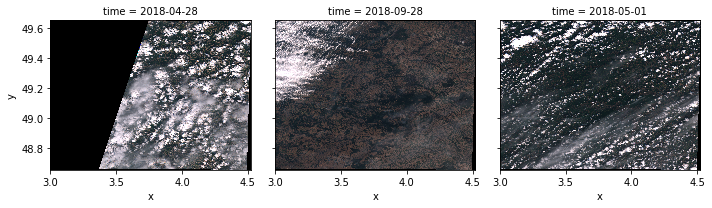

In [16]:
# Plot RGB 
rgb_bands = ['B04', 'B03', 'B02']
time_series_scenes.sel(band=rgb_bands).plot.imshow(col='time', robust=True)

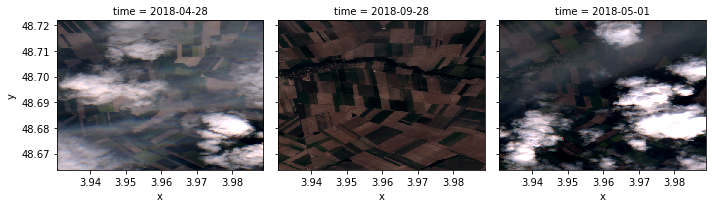

In [18]:
# Plot subset 
rgb_bands = ['B04', 'B03', 'B02']
sample = time_series_scenes[:,:, 8000:8500, 8000:8500]
sample.sel(band=rgb_bands).plot.imshow(col='time', robust=True)

In [8]:
time_series_scenes.dims

('time', 'band', 'y', 'x')

In [9]:
time_series_scenes.data

,Array,Chunk
Bytes,9.41 GB,524.29 kB
Shape,"(3, 14, 8572, 13071)","(1, 1, 512, 512)"
Count,92862 Tasks,18564 Chunks
Type,uint16,numpy.ndarray


**`Coords`** is a dict-like mapping names to values:

In [11]:

time_series_scenes.coords

Coordinates:
  * band     (band) object 'B02' 'B03' 'B04' 'B05' ... 'NDWI' 'SAVI' 'TRE'
  * y        (y) float64 49.65 49.65 49.65 49.65 ... 48.66 48.66 48.66 48.66
  * x        (x) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 4.52 4.52 4.52 4.52 4.521
  * time     (time) datetime64[ns] 2018-04-28 2018-09-28 2018-05-01

**`Attrs`** is a dict-like attaching metadata to the `DataArray`: 

In [12]:
time_series_scenes.attrs

{'transform': (0.000116357344215,
  0.0,
  2.9997229225525843,
  0.0,
  -0.000116357344215,
  49.652722814029225),
 'crs': '+init=epsg:4326',
 'res': (0.000116357344215, 0.000116357344215),
 'is_tiled': 1,
 'nodatavals': (0.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area'}

## Indexing and selecting data with xarray

xarray offers extremely flexible indexing routines that combine the best
features of NumPy and pandas for data selection.

In [9]:
%%time
select_band_time_compute = time_series_scenes.sel(band='NDVI', time='2018-04-28').compute()
select_band_time_compute

CPU times: user 1.24 s, sys: 293 ms, total: 1.53 s
Wall time: 2.16 s


<xarray.DataArray (time: 1, y: 8572, x: 13071)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
    band     <U4 'NDVI'
  * y        (y) float64 49.65 49.65 49.65 49.65 ... 48.66 48.66 48.66 48.66
  * x        (x) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 4.52 4.52 4.52 4.52 4.521
  * time     (time) datetime64[ns] 2018-04-28
Attributes:
    transform:      (0.000116357344215, 0.0, 2.9997229225525843, 0.0, -0.0001...
    crs:            +init=epsg:4326
    res:            (0.000116357344215, 0.000116357344215)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [8]:
%%time
select_band_time_values = time_series_scenes.sel(band='NDVI', time='2018-04-28').values
select_band_time_values

CPU times: user 1.25 s, sys: 288 ms, total: 1.54 s
Wall time: 2.19 s


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

In [29]:
# NDVI mean value over time 
mean = time_series_scenes.sel(band='NDVI').mean('time')
mean

<xarray.DataArray (y: 8720, x: 13293)>
dask.array<mean_agg-aggregate, shape=(8720, 13293), dtype=float64, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
    band     <U4 'NDVI'
  * y        (y) float64 49.64 49.64 49.64 49.64 ... 48.63 48.63 48.63 48.63
  * x        (x) float64 4.358 4.358 4.358 4.358 ... 5.904 5.904 5.904 5.905

In [34]:
# Select pixel values at position x,y with method nearest 

time_series_scenes.sel(x=4.6, y = 49.5, method ='nearest')

<xarray.DataArray (time: 78, band: 14)>
dask.array<getitem, shape=(78, 14), dtype=uint16, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) object 'B02' 'B03' 'B04' 'B05' ... 'NDWI' 'SAVI' 'TRE'
    y        float64 49.5
    x        float64 4.6
  * time     (time) datetime64[ns] 2018-05-28 2018-09-08 ... 2018-09-18
Attributes:
    transform:      (0.000116357344215, 0.0, 4.357910769844605, 0.0, -0.00011...
    crs:            +init=epsg:4326
    res:            (0.000116357344215, 0.000116357344215)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [35]:
# Index by integer array indices
time_series_scenes.isel(time=0)

,Array,Chunk
Bytes,3.25 GB,524.29 kB
Shape,"(14, 8720, 13293)","(1, 512, 512)"
Count,2562924 Tasks,6552 Chunks
Type,uint16,numpy.ndarray


## Groupby

In [10]:
#  Use group by year 
groub_by_year = time_series_scenes.groupby(time_series_scenes.time.dt.year)
groub_by_year

DataArrayGroupBy, grouped over 'year' 
1 groups with labels 2018.

## Dask best practices 
https://docs.dask.org/en/latest/best-practices.html

## Dask for parallel computing cheat sheet
https://docs.dask.org/en/latest/_downloads/283ae48258d4a12e74080caf194279cb/daskcheatsheet.pdf


## Familiar user interface

### Dask DataFrame mimics Pandas - documentation





In [ ]:
import pandas as pd                     import dask.dataframe as dd
df = pd.read_csv('2015-01-01.csv')      df = dd.read_csv('2015-*-*.csv')
df.groupby(df.user_id).value.mean()     df.groupby(df.user_id).value.mean().compute()

### Dask Array mimics NumPy - documentation

In [ ]:
import numpy as np                       import dask.array as da
f = h5py.File('myfile.hdf5')             f = h5py.File('myfile.hdf5')
x = np.array(f['/small-data'])           x = da.from_array(f['/big-data'],
                                                           chunks=(1000, 1000))
x - x.mean(axis=1)                       x - x.mean(axis=1).compute()


## Next steps

##  Parallel and Distributed Machine Learning

[Dask-ML](https://dask-ml.readthedocs.io) has resources for parallel and distributed machine learning.

## Types of Scaling

There are a couple of distinct scaling problems you might face.
The scaling strategy depends on which problem you're facing.

1. Large Models: Data fits in RAM, but training takes too long. Many hyperparameter combinations, a large ensemble of many models, etc.
2. Large Datasets: Data is larger than RAM, and sampling isn't an option.



